# Ciclope beam FE test
from CT image to beam-FE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 17.01.2024 <br />

- Data source: LHDL project (IOR Bologna, Italy)
- For more info on the dataset see the [LHDL homepage](http://projects.kmi.open.ac.uk/lhdl/)

For info on the solver see the [Calculix homepage](http://www.calculix.de/)

## Configuration

In [1]:
import sys
sys.path.append('./../../')

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import skeletonize, skeletonize_3d,  medial_axis
from skimage.util import invert
from skimage import measure, morphology
from skimage import data
import sknw

import networkx as nx

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes, plot_projections
from ciclope.utils.preprocess import remove_unconnected
import ciclope

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

In [3]:
# # for visualization with itkwidgets
# import itk
# from itkwidgets import view

In [4]:
# for the 3D plotting of a graph
# from mpl_toolkits.mplot3d import Axes3D

### Function definition

In [3]:
def network_plot_3D(G, angle=30, save=False):
    """Generate 3D plot of graph data."""

    # Get node positions
    pos = nx.get_node_attributes(G, 'pts')
    
    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])

    # Define color range proportional to number of edges adjacent to a single node
    colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 

    # 3D network plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Loop on the pos dictionary to extract the x,y,z coordinates of each node
    for key, value in pos.items():
        xi = value[0][0]
        yi = value[0][1]
        zi = value[0][2]

        # Scatter plot
        ax.scatter(xi, yi, zi, c=colors[key], s=20+20*G.degree(key), edgecolors='k', alpha=0.7)

    # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
    # Those two points are the extrema of the line to be plotted
    for i,j in enumerate(G.edges()):

        x = np.array((graph.nodes[j[0]]['pts'][0][0], graph.nodes[j[1]]['pts'][0][0]))
        y = np.array((graph.nodes[j[0]]['pts'][0][1], graph.nodes[j[1]]['pts'][0][1]))
        z = np.array((graph.nodes[j[0]]['pts'][0][2], graph.nodes[j[1]]['pts'][0][2]))
        # print(z)
        
        # Plot the connecting lines
        ax.plot(x, y, z, c='black', alpha=0.5)
    
    # Set the initial view
    ax.view_init(30, angle)

    # Hide the axes
    ax.set_axis_off()
    plt.show()

    return

In [4]:
def abaqus_beam_model(nodes, elements, thickness, n_boundary=None, fileout='pippo.inp', templatefile=None):
    """Generate ABAQUS beam Finite Element (FE) input file from graph data.
    The file written is an input file (.INP) in ABAQUS syntax that can be solved using ABAQUS or CALCULIX.
    Boundary conditions, analysis type and output requests are defined in a separate template file (see "tmp.inp" for an example).
    Info on analysis definition at: https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb

    Parameters
    ----------
    nodes : ndarry
        nodes array of type: [ID, x, y, z]
    elements : ndarray
        elements array of type: [ID_n1, ID_n2]
    thickness : ndarry
        element thickness array
    n_bounary : dict
        Dictionary of boundary node sets as follows:
        n_boundary = {
            'NODES_B': [0, 20, 32, ...],
            'NODES_T': [45, 52, 89, ...],
        }
    fileout : str
        Output .INP file.
    templatefile : str
        Analysis template file.
    eltype : str
        FE element type. The default is eight-node brick element (C3D8 and F3D8). See CalculiX node convention (Par. 6.2.1) at: http://www.dhondt.de/ccx_2.15.pdf
    verbose : bool
        Activate verbose output.
    """
    # open ABAQUS *.INP output file
    INP = open(fileout, 'w')

    # HEADER
    INP.write('** ---------------------------------------------------------\n')
    INP.write('** Abaqus .INP file written by ciclope')
    INP.write('** ---------------------------------------------------------\n')

    # NODE COORDINATES
    # logging.info('Writing model nodes to INP file')
    INP.write('** Node coordinates from input model\n')
    INP.write('*NODE, NSET=Nall\n')

    for node in nodes:
        INP.write('{0:4d}, {n[1]:12.6f}, {n[2]:12.6f}, {n[3]:12.6f}\n'.format(int(node[0]), n=node))

    # ELEMENTS AND ELEMENT SETS
    n_els = 0
    # logging.info('Writing model elements to INP file')
    INP.write('** Elements and Element sets from input model\n')
    INP.write('*ELEMENT, TYPE=b32, ELSET=Eall\n')
    i = 0

    # for each cell with that Grey Value
    el_count = 1
    for el in elements:
        # write element index followed by a list of its nodes
        INP.write('{0:4d}, {n[0]:4d}, {n[2]:4d}, {n[1]:4d}\n'.format(el_count, n=el))
        el_count += 1

    # NODE SETS
    INP.write('** Additional nset from voxel model. New generated nsets are:\n')
    if n_boundary is not None:
        for key, arg in n_boundary.items():
            INP.write('*NSET, NSET={0}\n'.format(key))
            for node in arg:
                INP.write('{}\n'.format(node))

            INP.write('\n')
        # logging.info('Additional nodes sets generated: {}'.format(list(mesh.point_sets)))

    # BOUNDARY CONDITIONS AND ANALYSIS DEFINITION
    # Open Abaqus analysis template file
    try:
        template = open(templatefile, 'r')
    except IOError('Abaqus template file {} not found.'.format(templatefile)):
        exit(1)
    # logging.info('Reading Abaqus template file {}'.format(templatefile))

    # copy line by line info on model solution and boundary conditions from Abaqus analysis template file
    for line in template.readlines():
        # write line to output Abaqus file
        INP.write('{}'.format(line))

    template.close()
    INP.close()
    # logging.info('Model with {0} nodes and {1} elements written to file {fname}'.format(len(mesh.points), len(mesh.cells[0]), fname=fileout))

    return

#### Load input data

In [5]:
# input_file = './../../test_data/LHDL/3155_D_4_bc/Tiny_crop/cropped-0000.tif'
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Energy| |
|Voxel size|19.5 micron|
|Preliminary operations|cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [6]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

Inspect the dataset

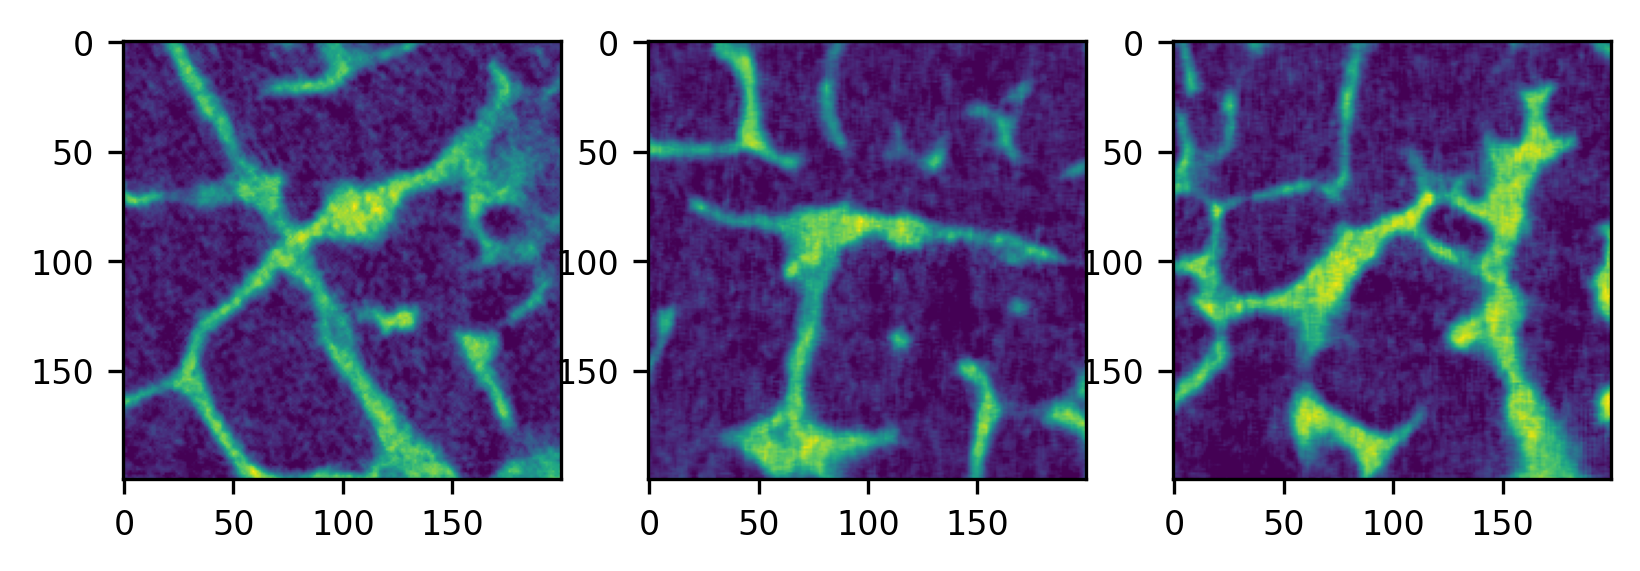

In [7]:
plot_midplanes(data_3D)
plt.show()

## Pre-processing
### Gaussian smooth

In [8]:
# data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Crop

In [6]:
data_3D_crop = data_3D[0:50,0:50,0:50]

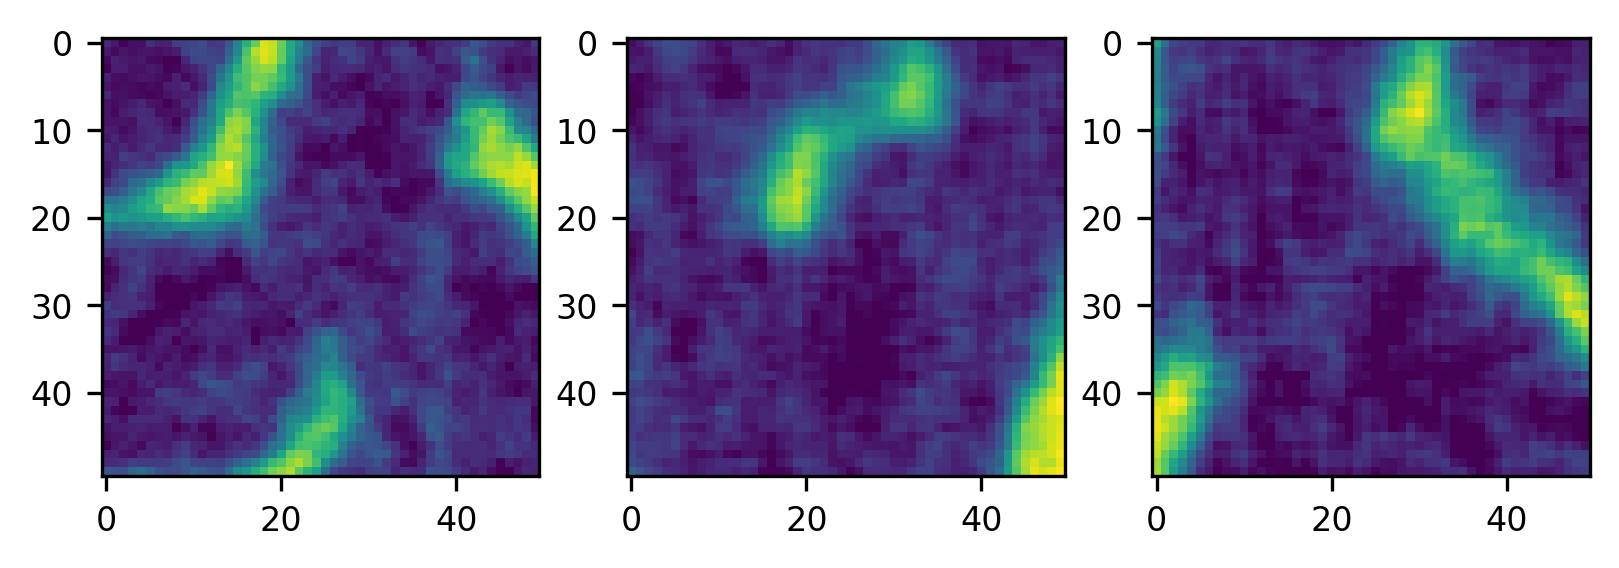

In [10]:
# Inspect again the dataset
# plot_midplanes(data_3D_crop, 10,10,10)
plot_midplanes(data_3D_crop)

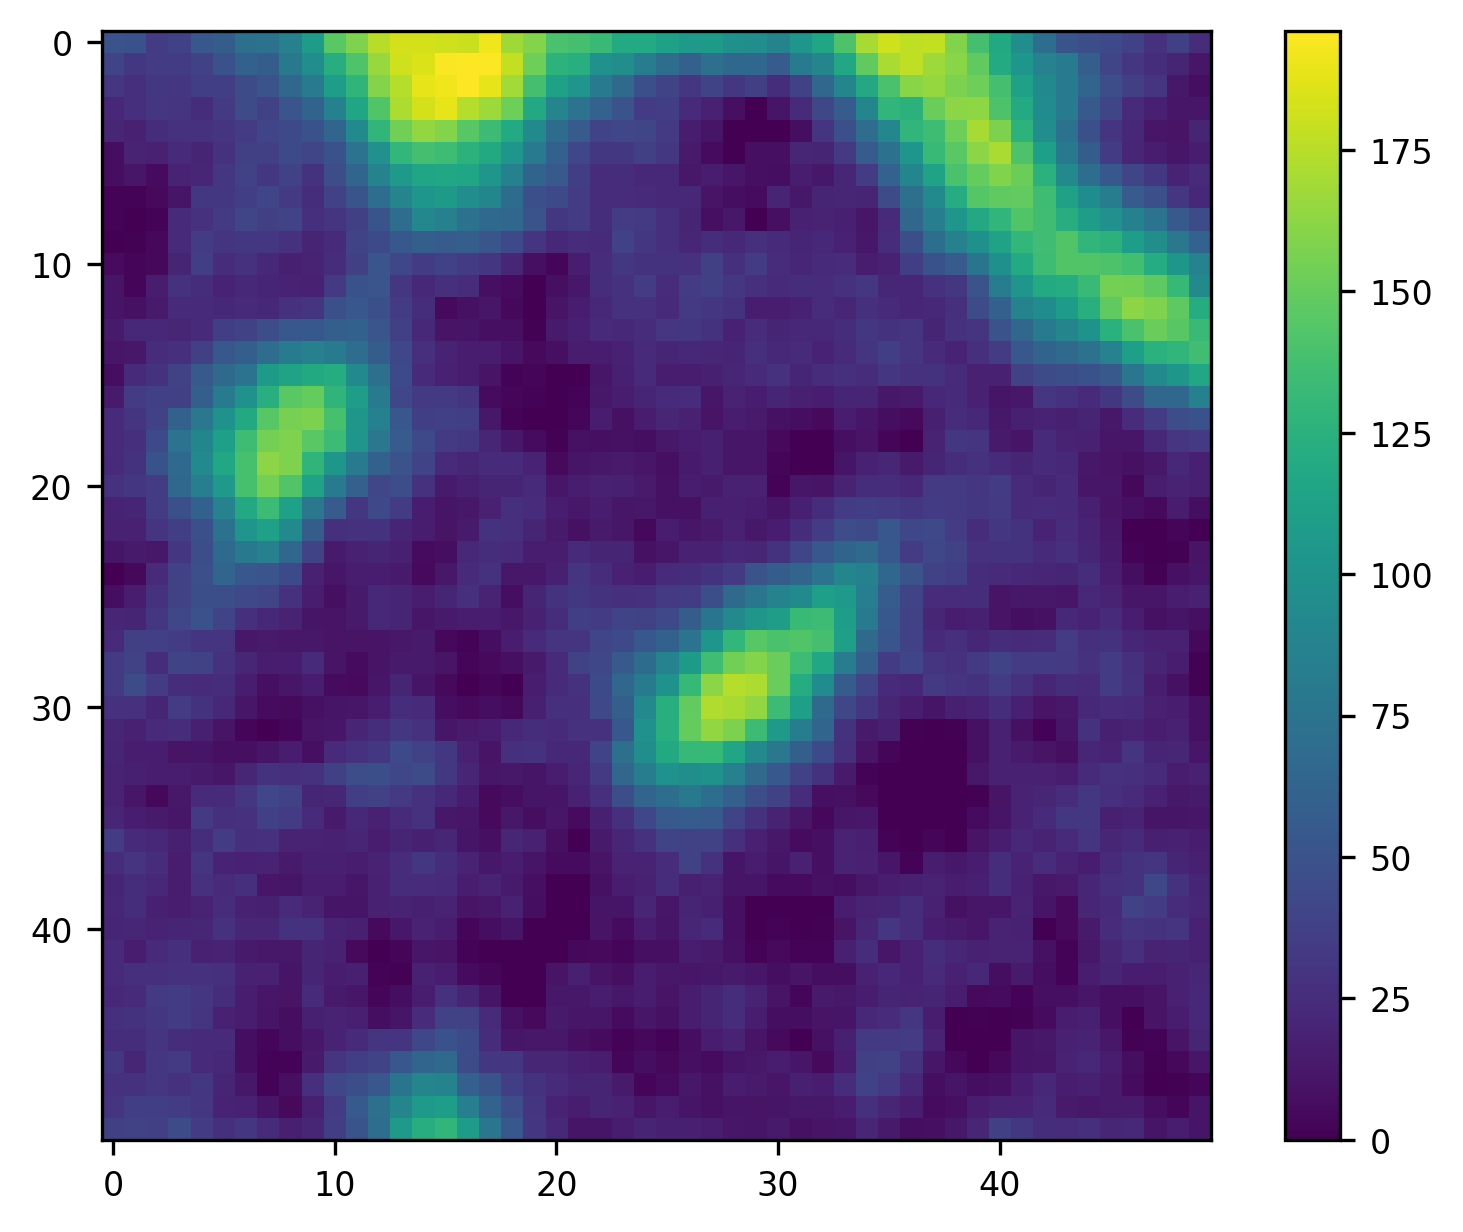

In [11]:
im = plt.imshow(data_3D_crop[0,:,:])
cbar = plt.colorbar(im)

### Thresholding


In [7]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 84


In [13]:
# # plot the input image histogram
# fig2, ax2 = plt.subplots()
# plt.hist(data_3D_crop[0,:,:].ravel(), bins=40)
# plt.show()

Apply the threshold

In [9]:
# BW = data_3D > T
# BW = data_3D_crop >= 112 # 52?? from comparison with histology
BW = data_3D >= 112 # 52?? from comparison with histology

Have a look at the binarized dataset

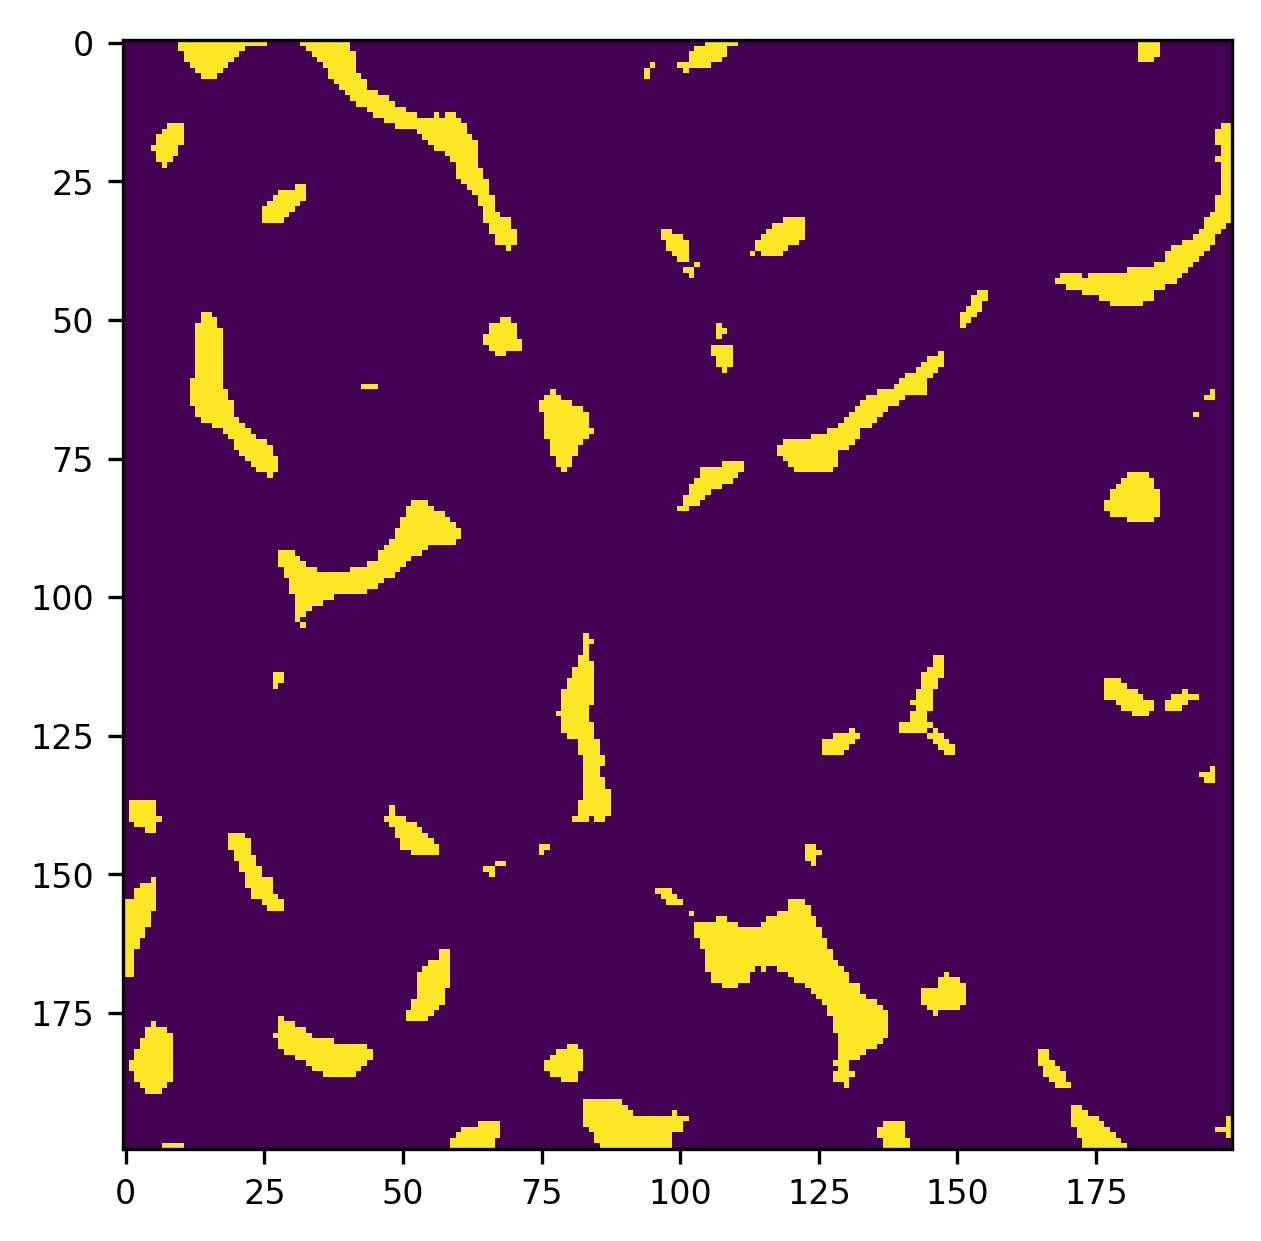

In [10]:
plt.imshow(BW[0,:,:])

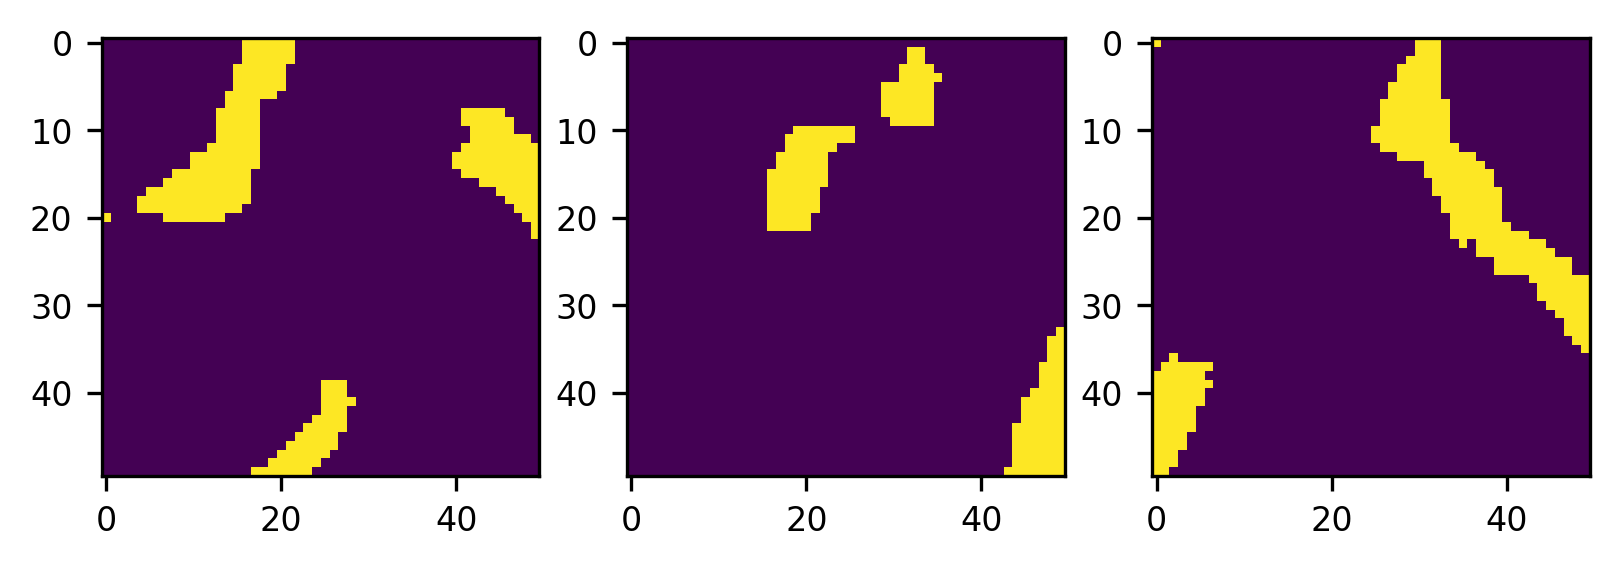

In [16]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [17]:
# BW = morphology.closing(BW, morphology.ball(3))

### Detect largest isolated cluster of voxels

In [11]:
BW = remove_unconnected(BW)

### Distance transform from the image background

In [12]:
dist = ndimage.distance_transform_edt(BW)

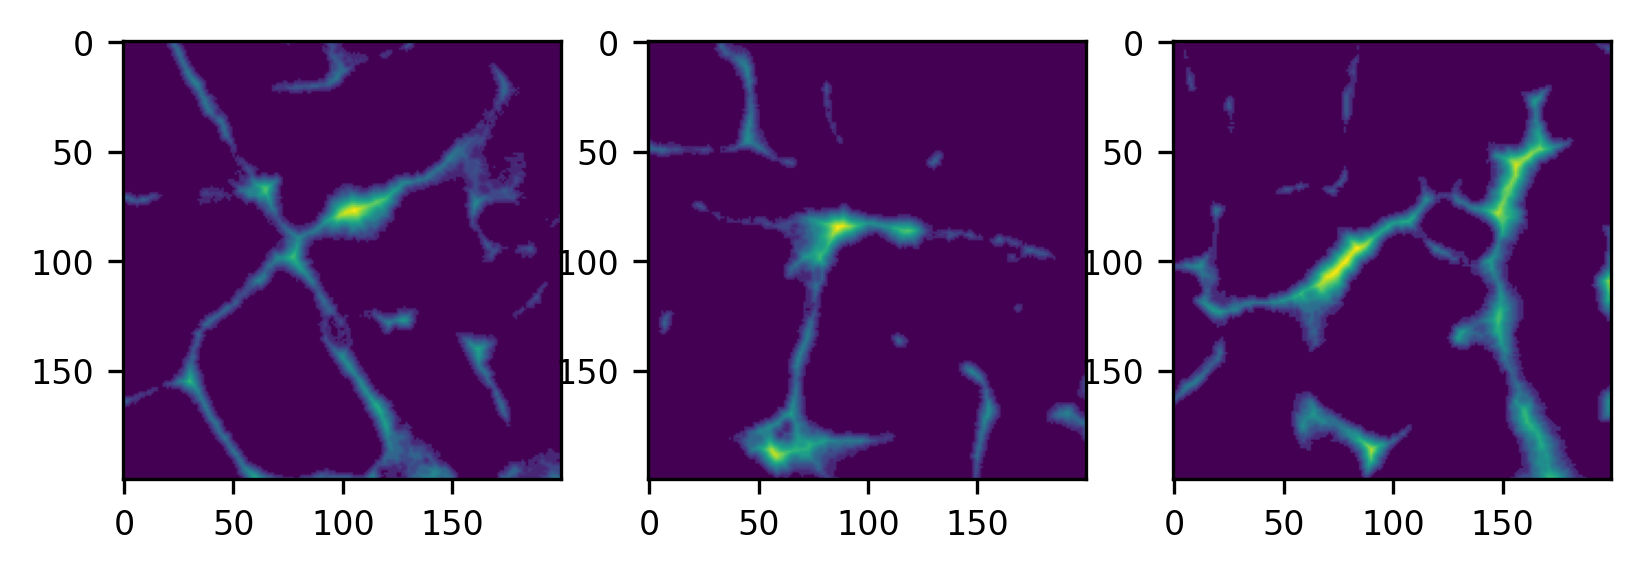

In [13]:
plot_midplanes(dist)

---
## Skeletonization with `skimage.skeletonize_3d`
https://github.com/seung-lab/cloud-volume/wiki/Advanced-Topic:-Skeletons

Invert the image

In [19]:
# inverseBW = invert(BW)

3D skeletonization with [scikit.skeletonization_3d]()

In [14]:
ske = skeletonize_3d(BW).astype(np.uint8)

Plot max-projs of the skeleton

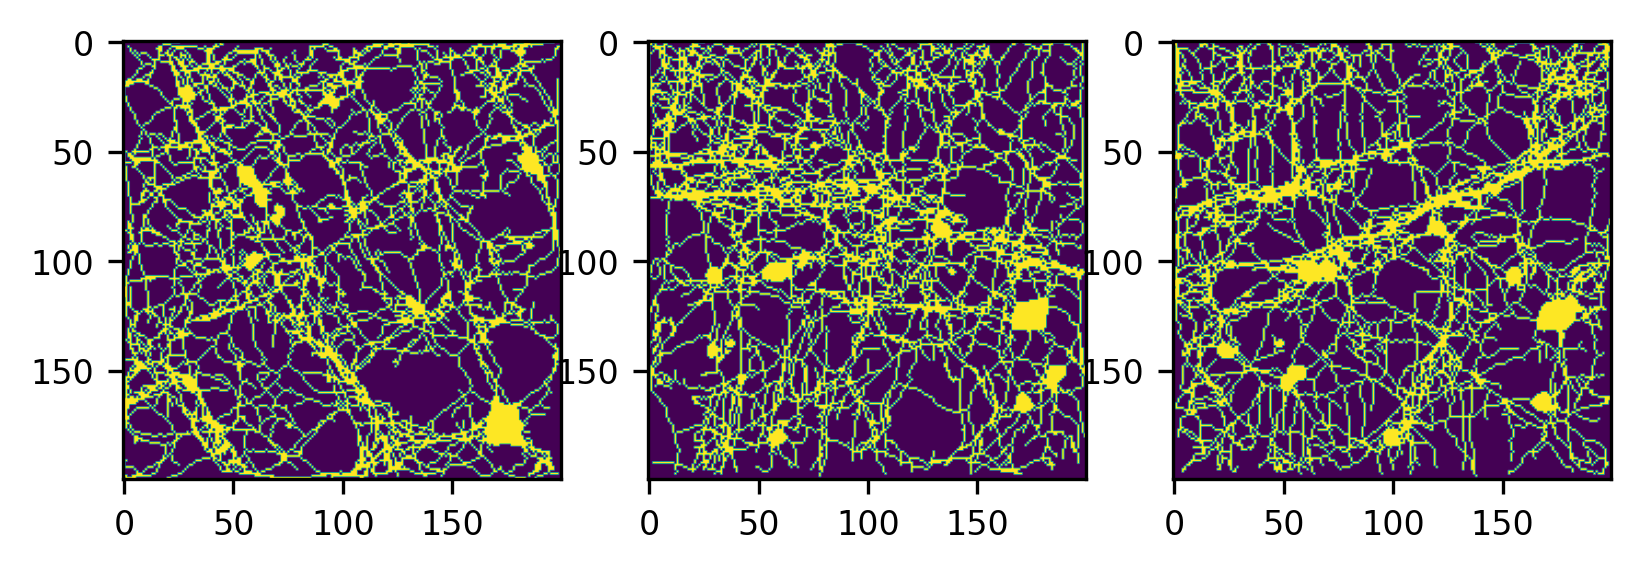

In [15]:
# plot_midplanes(ske)
plot_projections(ske)

Display with itkviewer

In [22]:
# # viewer = view(skeletonBW, ui_collapsed=True)
# viewer = view(ske, ui_collapsed=True)
# viewer.interpolation = False
# viewer
# view(ske)

Compute the medial axis (skeleton) and the distance transform

In [23]:
# skel, distance = medial_axis(BW, return_distance=True) # not working for 3D images!

---
### Compute graph from the skeleton using the [sknw](https://github.com/Image-Py/sknw) package

build graph from skeleton

In [16]:
graph = sknw.build_sknw(ske)

In [17]:
graph.number_of_nodes()

1231

---
### Graph object contents:

ref for inspection of graph contents and methods:
[networkx](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html)

- `graph.edges(i)` lists the connectivity of node `i` (i.e. all the arcs of the graph leaving node `i`)

> **_NOTE:_**  `graph.edges` corresponds to the graph arcs!

- `graph.nodes[i]` stores the coordinates of all voxels classified as graph node `i`. One graph node can be one or more voxels.
    - `graph.nodes[i]['pts']`: points identified as node `i` 
    - `graph.nodes[i]['o']`: origin of node `i` as average of `pts`
- `graph.degree(i)` reports the degree of connectivity of node `i` (i.e. number of arcs connected to node `i`
- `graph.adj[i][j]` reports the two fields `pts` and `weight` for the arc `i-j`
    - `graph.adj[i][j]['pts']` lists the coordinates of voxels belonging to the arc `i-j`. This is equivalent to the call `graph[i][j]['pts']`

For instance, print the connectivity of node `176`:

In [27]:
id = 17
graph.edges(id)

EdgeDataView([(17, 11), (17, 19), (17, 16)])

Print the coordinates of all points belonging to the graph arc between nodes `176` and `5`:

In [29]:
# graph[0][5]['pts']

the coordinates of these nodes are stored in `graph.nodes`

---
#### Plotting the graph

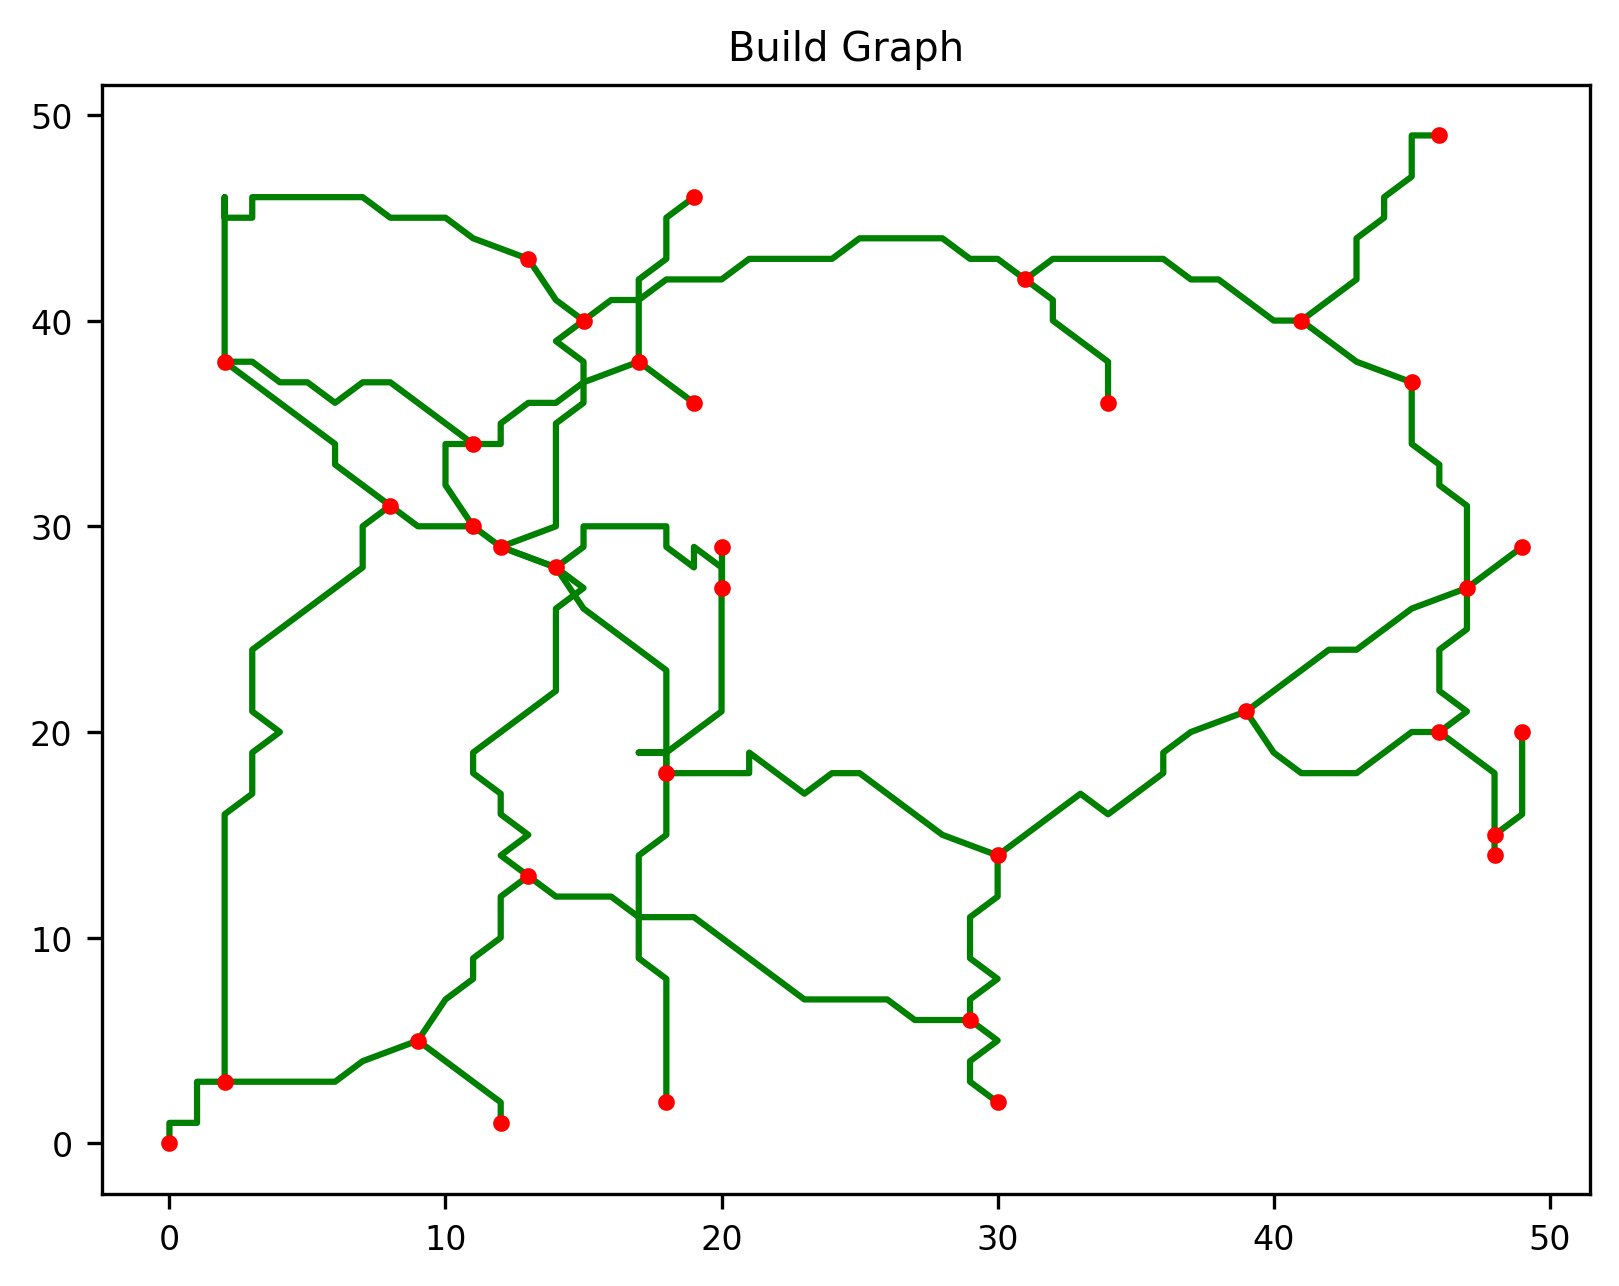

In [30]:
# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

Plot the graph in 3D with
`network_plot_3D(graph, angle)`

/tmp/ipykernel_923712/2606459254.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xi, yi, zi, c=colors[key], s=20+20*G.degree(key), edgecolors='k', alpha=0.7)


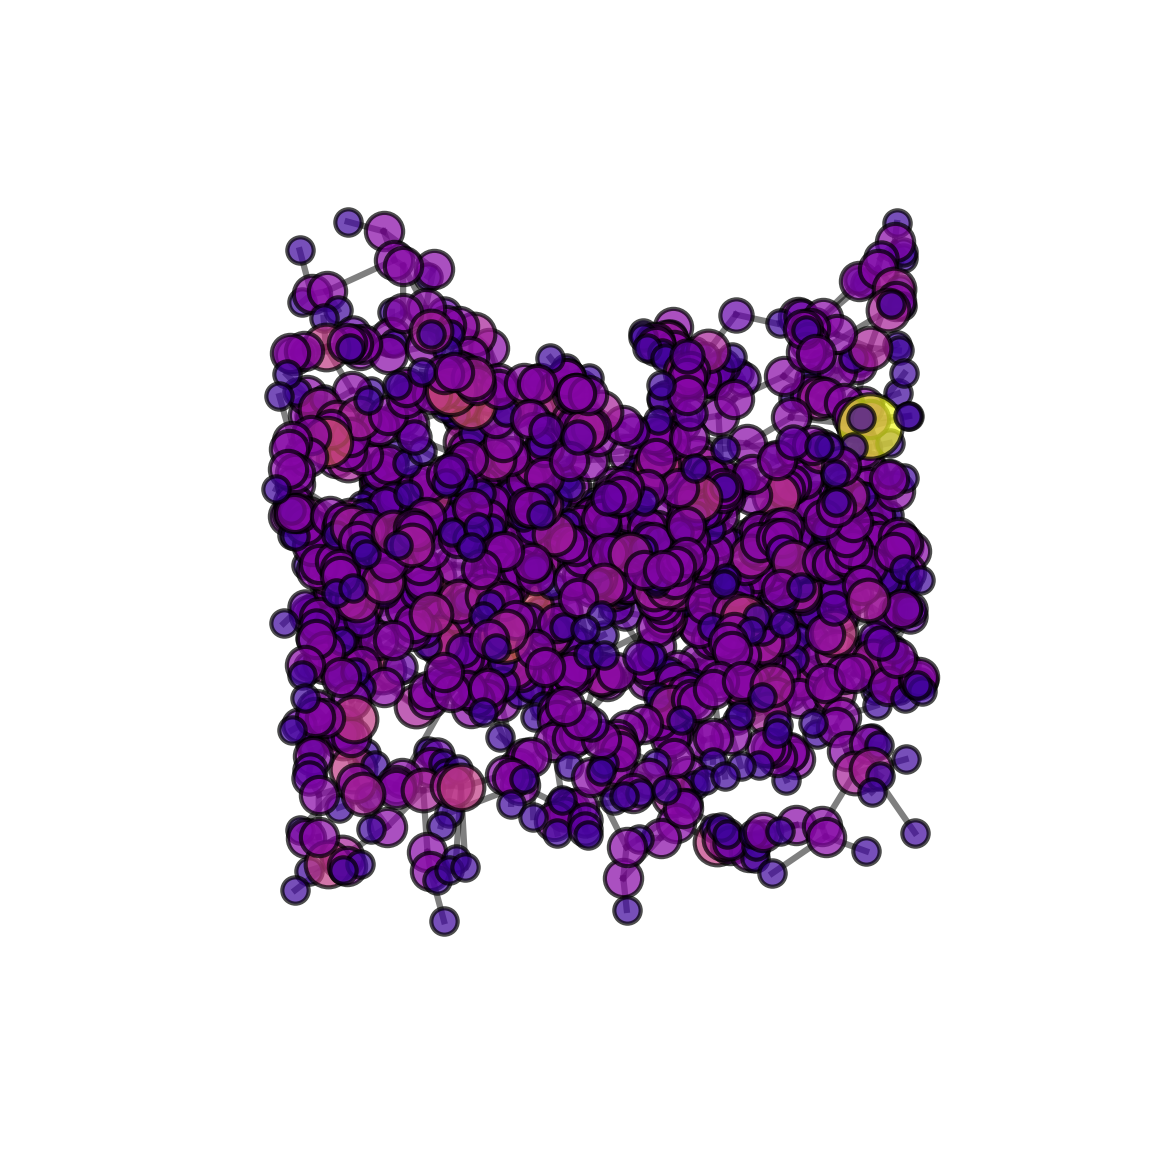

In [19]:
network_plot_3D(graph, 0)

---
## Assemble arrays for FE model creation
- `nodes: [ID, x, y, z]`
- `elements: [ID_n1, ID_n2]`
> **_NOTE:_**  Node indexes start from 1!

In [20]:
# initialize nodes array
nodes = np.zeros((graph.number_of_nodes(),4), dtype=float)
print(nodes.shape)

(1231, 4)


In [21]:
for n in range(0,graph.number_of_nodes()):
    nodes[n, 0]  = n+1
    nodes[n, 1:] = graph.nodes[n]['o']

In [22]:
elements = np.array(list(graph.edges()))

In [23]:
th = np.zeros((elements.shape[0]))

In [24]:
# get max thickness of the arc
for n in range(0, len(th)):
    # print(n)
    voxels = graph[elements[int(n),0]][elements[int(n),1]]['pts']
    # print(voxels.shape)
    th_array = np.zeros((voxels.shape[0],1))
    count = 0
    for v in voxels:
        th_array[count] = dist[v[0], v[1], v[2]]
        count += 1
    th[n] = np.max(th_array)

## Add mid-point of each element:
- nodes: append mid-point node coordinates at the end of nodes array (n. of rows corresponiding to n. el will be added)
- elements: add third column corresponding to the row of the midpoint node in matrix nodes 

In [25]:
added_node_id = np.zeros((elements.shape[0],1))

In [26]:
added_node_coors = np.zeros((elements.shape[0],4))

In [27]:
# find mid node for each arc
new_e_count = nodes.shape[0]
for e in range(0,elements.shape[0]):
    n1 = elements[e,0]
    n2 = elements[e,1]
    
    coords = np.array([nodes[n1,1:],
                       nodes[n2,1:]])
    
    n3 = np.mean(coords, axis=0)
    
    added_node_id[e] = new_e_count
    added_node_coors[e,0] = new_e_count+1
    added_node_coors[e,1:] = n3
    new_e_count += 1

In [28]:
nodes_new = np.concatenate((nodes, added_node_coors), axis=0)

In [29]:
elements_new = np.concatenate((elements, added_node_id), axis=1).astype('uint8')

## Find Boundary nodes

In [35]:
z_min = np.min(nodes_new[:,3])
z_max = np.max(nodes_new[:,3])
d_z = z_max-z_min
clp=5/100
print('Z min:', z_min)
print('Z max:', z_max)

Z min: 0.0
Z max: 199.0


In [36]:
idx_NODES_TOP = np.where(nodes_new[:,3] >= (z_min+(1-clp)*d_z))

In [37]:
idx_NODES_BOTTOM = np.where(nodes_new[:,3] <= (z_min+clp*d_z))

In [38]:
n_boundary = {'NODES_T': idx_NODES_TOP[0]+1,
              'NODES_B': idx_NODES_BOTTOM[0]+1,
             }

## Write `.INP` output file

In [323]:
abaqus_beam_model(nodes_new, elements_new, th, n_boundary, fileout='pippo.inp', templatefile='/home/gianthk/PycharmProjects/ciclope/input_templates/tmp_example02_tens_static_steel.inp')

---
## Trabecular local thickness

The local diameter of single trabeculae can be measured by combining the skeleton and the distance transform to the background [Gouillart_2017](https://hal.archives-ouvertes.fr/hal-01448271).

- Gouillart, Emmanuelle, Juan Nunez-Iglesias, and Stéfan van Der Walt. 2017. “Analyzing Microtomography Data with Python and the Scikit-Image Library.” Advanced Structural and Chemical Imaging 2: 18. https://doi.org/10.1186/s40679-016-0031-0.

---
> ## **Update: ITK has an [ITKThickness3D](https://github.com/T4mmi/ITKThickness3D) Python module for both skeleonization and local thickness tested for trabecular bone. Consider migrating to this module!!**
> - **Binary thinning** provides a 1 pixel-thin wire skeleton using an efficient curve thinning algorithm. The thinning algorithm used in this module comes from the Insight Journal article:
    - Homann H., Implementation of a 3D thinning algorithm. The Insight Journal - 2007 July - December. http://hdl.handle.net/1926/1292; http://insight-journal.org/browse/publication/181
> - **Medial thickness** computes twice the shortest distance to the outter shell along the medial axis of the object (i.e. diameter of the local maximal fitting sphere).

### Mask the distance transform with skeleton image
Convert the skeleton to a mask

In [43]:
ske01 = ciclope.utils.recon_utils.to01(ske).astype(bool)

Masking operation

In [53]:
masked = dist.copy().astype('uint8')

In [54]:
masked[~ske01] = 0

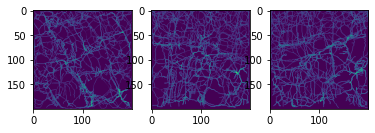

In [55]:
plot_projections(masked)

Write skeleton image as stack of TIFFs for inspection

In [51]:
import dxchange

In [56]:
dxchange.write_tiff_stack(masked, "/home/gianthk/PycharmProjects/CT2FE/test_data/LHDL/3155_D_4_bc/results/skeleton/slice.tiff")

Visualize in ParaView

![skeleton](./../../test_data/LHDL/3155_D_4_bc/results/skeleton.png)

---
### [Skeletor](https://pypi.org/project/skeletor/) turns meshes into skeletons

In [243]:
#pip3 install skeletor
import skeletor as sk
mesh = sk.example_mesh()
fixed = sk.pre.fix_mesh(mesh, remove_disconnected=5, inplace=False)
skel = sk.skeletonize.by_wavefront(fixed, waves=1, step_size=1)
#skel = skeletor.skeletonize.by_teasar()
#Skeleton(BW, mesh=mesn, mesh_map=None, method=None)

Skeletonizing:   0%|          | 0/6213 [00:00<?, ?it/s]